In [ ]:
# MovieLens Case Analysis with DuckDB (100K → 32M)

#Group members:
#- Joao Andre Mateus Neves (20241487)
#- Leonardo Pereira (20240820)
#- Name 3 (Student ID)
#- Name 4(Student ID)

## Project Summary
#We demonstrate how movie analytics scale from 100K to 25M ratings using DuckDB and Python. This notebook parallels our presentation and walks through each analysis step-by-step.


In [ ]:
!pip install duckdb

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("default")


In [ ]:
# Download 100K MovieLens dataset
!wget -q https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

# folder
!ls ml-100k

# main files
print("u.data (ratings) – first 5 lines:")
!head -5 ml-100k/u.data

print("\nu.item (movies) – first 5 lines:")
!head -5 ml-100k/u.item

print("\nu.genre (genres):")
!head -5 ml-100k/u.genre


allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item
u.data (ratings) – first 5 lines:
196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596

u.item (movies) – first 5 lines:
1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0

u.genre (ge

In [ ]:
# Connect to an in-memory DuckDB database
con = duckdb.connect(database=":memory:")

# 3.1 Load ratings (u.data) directly in DuckDB — no encoding issues
con.execute("""
CREATE TABLE ratings AS
SELECT
    CAST(column0 AS INTEGER) AS user_id,
    CAST(column1 AS INTEGER) AS movie_id,
    CAST(column2 AS INTEGER) AS rating,
    CAST(column3 AS BIGINT)  AS timestamp
FROM read_csv_auto(
    'ml-100k/u.data',
    delim='\t',
    header=False
);
""")

# 3.2 Load movies (u.item) — using pandas to bypass encoding problems
import pandas as pd

# Read with Latin-1 so all special characters load correctly
movies_df = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    header=None,
    encoding="latin1"
)

movie_cols = [
    "movie_id", "title", "release_date", "video_release_date",
    "imdb_url",
    "unknown", "Action", "Adventure", "Animation", "Children",
    "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "FilmNoir", "Horror", "Musical", "Mystery", "Romance",
    "SciFi", "Thriller", "War", "Western"
]

movies_df.columns = movie_cols

# Insert into DuckDB
con.execute("CREATE TABLE movies AS SELECT * FROM movies_df")

# Fix types
con.execute("UPDATE movies SET movie_id = CAST(movie_id AS INTEGER);")

# 3.3 Load genres mapping (u.genre) — also via pandas to avoid encoding errors
genres_df = pd.read_csv(
    "ml-100k/u.genre",
    sep="|",
    header=None,
    encoding="latin1",
    names=["genre_name", "genre_id"]
)

# Remove blank lines
genres_df = genres_df.dropna()

con.execute("CREATE TABLE genres AS SELECT * FROM genres_df;")


In [ ]:
print("Ratings count:", con.execute("SELECT COUNT(*) FROM ratings").fetchone()[0])
print("Movies count:", con.execute("SELECT COUNT(*) FROM movies").fetchone()[0])
print("Genres mapping:")
con.execute("SELECT * FROM genres").df().head()


Ratings count: 100000
Movies count: 1682
Genres mapping:


,genre_name,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [ ]:
#Basic dataset overview

overview = con.execute("""
SELECT
    (SELECT COUNT(DISTINCT user_id) FROM ratings) AS n_users,
    (SELECT COUNT(DISTINCT movie_id) FROM ratings) AS n_movies_rated,
    (SELECT COUNT(*) FROM movies) AS n_movies_total,
    (SELECT COUNT(*) FROM ratings) AS n_ratings
""").df()

overview


,n_users,n_movies_rated,n_movies_total,n_ratings
0,943,1682,1682,100000


In [ ]:
genre_columns = [
    "unknown", "Action", "Adventure", "Animation", "Children",
    "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "FilmNoir", "Horror", "Musical", "Mystery", "Romance",
    "SciFi", "Thriller", "War", "Western"
]

# Build a union-all query to normalize genres
union_parts = []
for g in genre_columns:
    union_parts.append(f"""
    SELECT
        movie_id,
        title,
        '{g}' AS genre
    FROM movies
    WHERE CAST({g} AS INTEGER) = 1
    """)
movie_genres_query = " UNION ALL ".join(union_parts)

con.execute(f"""
CREATE TABLE movie_genres AS
{movie_genres_query}
""")

# Distinct genres
distinct_genres = con.execute("""
SELECT DISTINCT genre
FROM movie_genres
ORDER BY genre;
""").df()

distinct_genres


,genre
0,Action
1,Adventure
2,Animation
3,Children
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Fantasy
9,FilmNoir


In [ ]:
movies_per_genre = con.execute("""
SELECT genre, COUNT(*) AS n_movies
FROM movie_genres
GROUP BY genre
ORDER BY n_movies DESC;
""").df()

movies_per_genre


,genre,n_movies
0,Drama,725
1,Comedy,505
2,Action,251
3,Thriller,251
4,Romance,247
5,Adventure,135
6,Children,122
7,Crime,109
8,SciFi,101
9,Horror,92


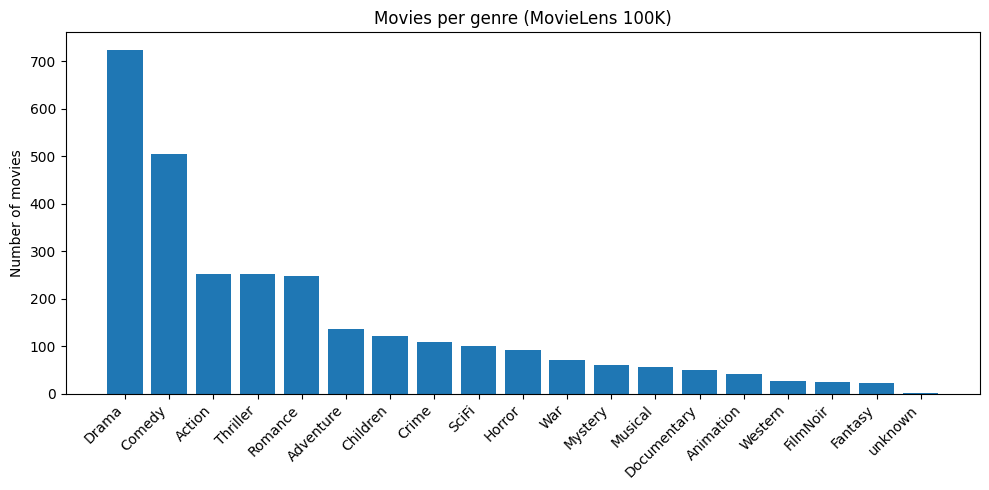

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(movies_per_genre["genre"], movies_per_genre["n_movies"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of movies")
plt.title("Movies per genre (MovieLens 100K)")
plt.tight_layout()
plt.show()


In [ ]:
user_stats = con.execute("""
SELECT
    user_id,
    COUNT(*) AS n_ratings,
    AVG(rating) AS avg_rating
FROM ratings
GROUP BY user_id
""").df()

user_stats.head()


,user_id,n_ratings,avg_rating
0,1,272,3.610294
1,2,62,3.709677
2,3,54,2.796296
3,4,24,4.333333
4,5,175,2.874286


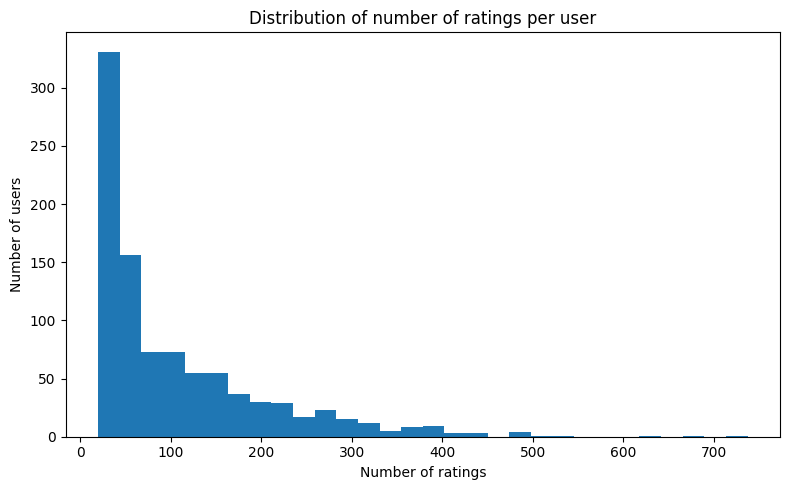

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(user_stats["n_ratings"], bins=30)
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")
plt.title("Distribution of number of ratings per user")
plt.tight_layout()
plt.show()


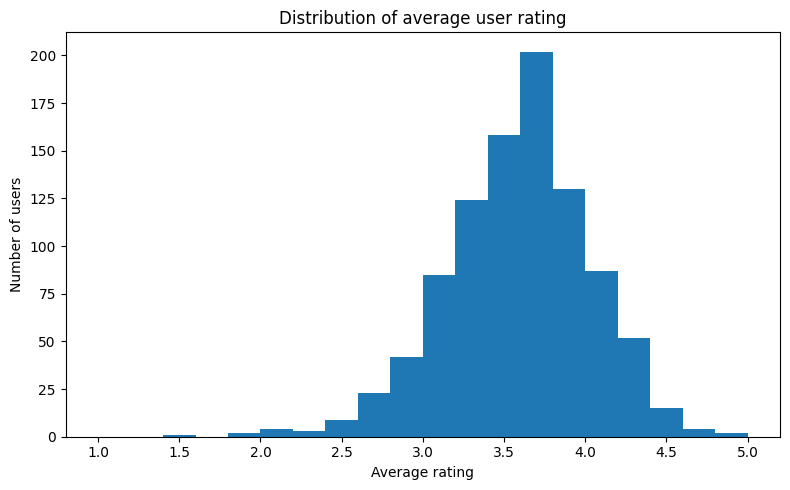

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(user_stats["avg_rating"], bins=20, range=(1,5))
plt.xlabel("Average rating")
plt.ylabel("Number of users")
plt.title("Distribution of average user rating")
plt.tight_layout()
plt.show()


In [ ]:
top_movies = con.execute("""
SELECT
    m.title,
    COUNT(*) AS n_ratings,
    AVG(r.rating) AS avg_rating
FROM ratings r
JOIN movies m USING (movie_id)
GROUP BY m.movie_id, m.title
HAVING COUNT(*) >= 50
ORDER BY avg_rating DESC, n_ratings DESC
LIMIT 20;
""").df()

top_movies


,title,n_ratings,avg_rating
0,"Close Shave, A (1995)",112,4.491071
1,Schindler's List (1993),298,4.466443
2,"Wrong Trousers, The (1993)",118,4.466102
3,Casablanca (1942),243,4.456790
4,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761
5,"Shawshank Redemption, The (1994)",283,4.445230
6,Rear Window (1954),209,4.387560
7,"Usual Suspects, The (1995)",267,4.385768
8,Star Wars (1977),583,4.358491
9,12 Angry Men (1957),125,4.344000


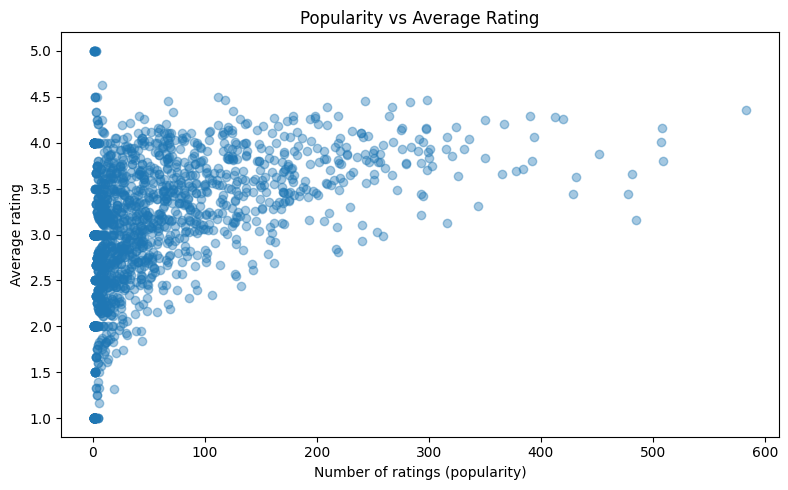

In [ ]:
pop_rating = con.execute("""
SELECT
    m.title,
    COUNT(*) AS n_ratings,
    AVG(r.rating) AS avg_rating
FROM ratings r
JOIN movies m USING (movie_id)
GROUP BY m.movie_id, m.title
""").df()

plt.figure(figsize=(8,5))
plt.scatter(pop_rating["n_ratings"], pop_rating["avg_rating"], alpha=0.4)
plt.xlabel("Number of ratings (popularity)")
plt.ylabel("Average rating")
plt.title("Popularity vs Average Rating")
plt.tight_layout()
plt.show()


In [ ]:
decade_rating = con.execute("""
SELECT
    CAST(SUBSTR(release_date, 8, 4) AS INTEGER) / 10 * 10 AS decade,
    AVG(r.rating) AS avg_rating,
    COUNT(*) AS n_ratings
FROM ratings r
JOIN movies m USING (movie_id)
WHERE release_date IS NOT NULL AND release_date <> ''
GROUP BY decade
HAVING decade IS NOT NULL
ORDER BY decade;
""").df()

decade_rating


,decade,avg_rating,n_ratings
0,971.0,1.000000,1
1,1922.0,3.555556,54
2,1926.0,3.000000,2
3,1930.0,3.777778,18
4,1931.0,4.000000,44
...,...,...,...
67,1994.0,3.424716,8893
68,1995.0,3.366702,10499
69,1996.0,3.324538,19708
70,1997.0,3.375151,17393


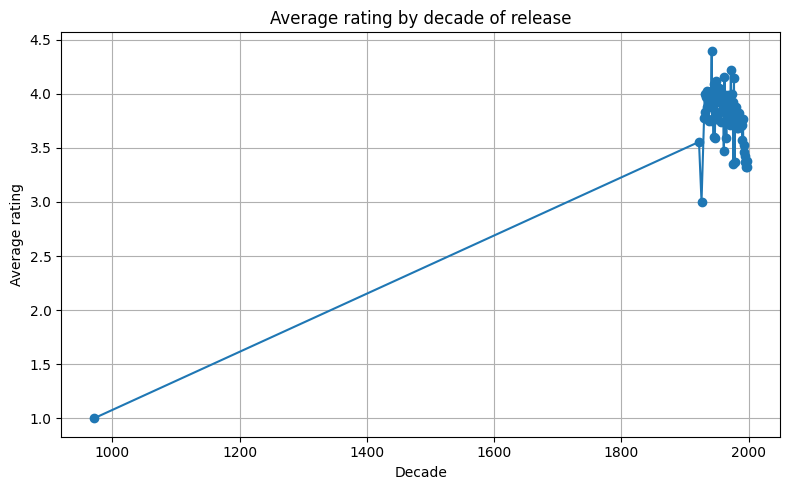

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(decade_rating["decade"], decade_rating["avg_rating"], marker="o")
plt.xlabel("Decade")
plt.ylabel("Average rating")
plt.title("Average rating by decade of release")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
user_genre = con.execute("""
SELECT
    r.user_id,
    mg.genre,
    AVG(r.rating) AS avg_rating
FROM ratings r
JOIN movie_genres mg USING (movie_id)
GROUP BY r.user_id, mg.genre;
""").df()

user_genre.head()


,user_id,genre,avg_rating
0,186,Thriller,3.588235
1,22,Comedy,2.986111
2,244,Western,3.000000
3,6,Drama,3.730769
4,62,SciFi,3.628571


In [ ]:
# END OF 100K DB

# 25M DB SECTION STARTS HERE

!wget -q https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip -q ml-25m.zip

!ls ml-25m


replace ml-25m/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [ ]:
con.execute("""
CREATE TABLE ratings_25m AS
SELECT *
FROM read_csv_auto('ml-25m/ratings.csv');
""")

con.execute("SELECT COUNT(*) FROM ratings_25m").df()

,count_star()
0,25000095


In [ ]:
con.execute("""
CREATE TABLE movies_25m AS
SELECT *
FROM read_csv_auto('ml-25m/movies.csv');
""")

con.execute("SELECT COUNT(*) FROM movies_25m").df()


,count_star()
0,62423


In [ ]:
#1. Rating distribution
con.execute("""
SELECT rating, COUNT(*) AS n
FROM ratings_25m
GROUP BY rating
ORDER BY rating;
""").df()

#2. Movies with the most ratings
top_popular_25m = con.execute("""
SELECT
    movieId,
    COUNT(*) AS n_ratings
FROM ratings_25m
GROUP BY movieId
ORDER BY n_ratings DESC
LIMIT 20;
""").df()

top_popular_25m

#3. Highest-rated movies (with threshold)
top_movies_25m = con.execute("""
SELECT
    m.title,
    COUNT(*) AS n_ratings,
    AVG(r.rating) AS avg_rating
FROM ratings_25m r
JOIN movies_25m m USING (movieId)
GROUP BY m.movieId, m.title
HAVING COUNT(*) >= 1000
ORDER BY avg_rating DESC
LIMIT 20;
""").df()

top_movies_25m

,title,n_ratings,avg_rating
0,Planet Earth II (2016),1124,4.483096
1,Planet Earth (2006),1747,4.464797
2,"Shawshank Redemption, The (1994)",81482,4.413576
3,Band of Brothers (2001),1356,4.398599
4,"Godfather, The (1972)",52498,4.324336
5,"Usual Suspects, The (1995)",55366,4.284353
6,"Godfather: Part II, The (1974)",34188,4.261759
7,Seven Samurai (Shichinin no samurai) (1954),13367,4.254769
8,Schindler's List (1993),60411,4.247579
9,12 Angry Men (1957),16569,4.243014


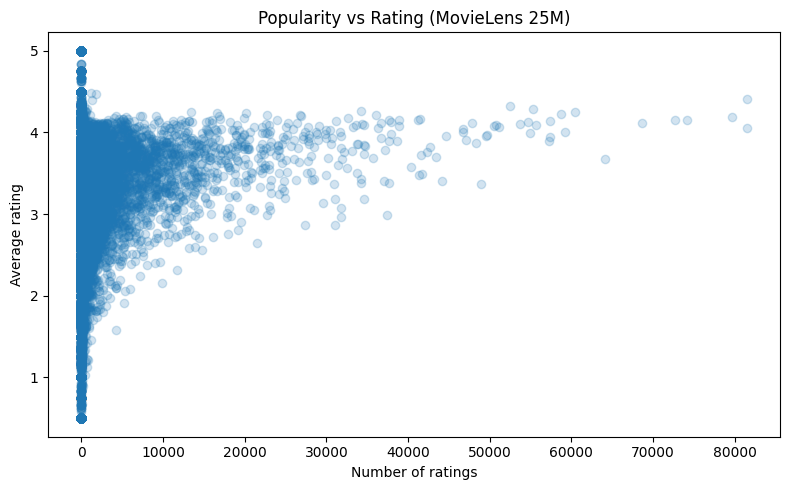

In [ ]:
# SECTION 3 - Comparing100K vs 25M (32M) DBs

#1. Comparing number of movies
con.execute("""
SELECT
    (SELECT COUNT(*) FROM movies)      AS movies_100k,
    (SELECT COUNT(*) FROM movies_25m) AS movies_25m;
""").df()

#2. Comparing number of ratings
con.execute("""
SELECT
    (SELECT COUNT(*) FROM ratings)      AS ratings_100k,
    (SELECT COUNT(*) FROM ratings_25m) AS ratings_25m;
""").df()

#3. Comparing popularity vs rating trends


pop_rating_25m = con.execute("""
SELECT
    movieId,
    COUNT(*) AS n_ratings,
    AVG(rating) AS avg_rating
FROM ratings_25m
GROUP BY movieId
""").df()




plt.figure(figsize=(8,5))
plt.scatter(pop_rating_25m["n_ratings"], pop_rating_25m["avg_rating"], alpha=0.2)
plt.xlabel("Number of ratings")
plt.ylabel("Average rating")
plt.title("Popularity vs Rating (MovieLens 25M)")
plt.tight_layout()
plt.show()

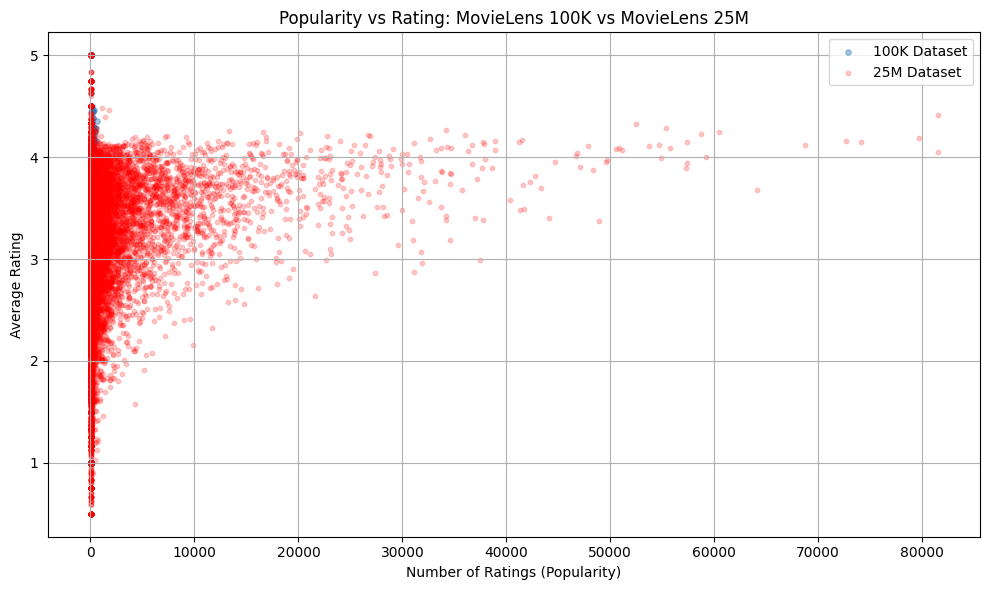

In [ ]:
# --- 1. POPULARITY VS RATING FOR 100K ---------------------------------------

pop_rating_100k = con.execute("""
SELECT
    movie_id AS movieId,
    COUNT(*) AS n_ratings,
    AVG(rating) AS avg_rating
FROM ratings
GROUP BY movie_id
""").df()

# --- 2. POPULARITY VS RATING FOR 25M ----------------------------------------

pop_rating_25m = con.execute("""
SELECT
    movieId,
    COUNT(*) AS n_ratings,
    AVG(rating) AS avg_rating
FROM ratings_25m
GROUP BY movieId
""").df()

# --- 3. COMPARISON PLOT ------------------------------------------------------

plt.figure(figsize=(10,6))

# 100K dataset (blue)
plt.scatter(
    pop_rating_100k["n_ratings"],
    pop_rating_100k["avg_rating"],
    alpha=0.4,
    label="100K Dataset",
    s=15
)

# 25M dataset (red)
plt.scatter(
    pop_rating_25m["n_ratings"],
    pop_rating_25m["avg_rating"],
    alpha=0.2,
    label="25M Dataset",
    s=10,
    color="red"
)

plt.xlabel("Number of Ratings (Popularity)")
plt.ylabel("Average Rating")
plt.title("Popularity vs Rating: MovieLens 100K vs MovieLens 25M")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


What this plot shows is that:

The 100K dataset (blue) is small and noisy.

The 25M dataset (red) is much denser and reveals clearer patterns:

Popular movies tend to have more moderate ratings (~3.5–4.0).

Very high-rated movies typically have low to medium popularity.

Extremely popular movies rarely achieve very high average ratings.

This is a classic statistical effect called regression to the mean.